Advanced lane finding
=====================

> The goals / steps of this project are the following: 
> * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
> * Apply a distortion correction to raw images.
> * Use color transforms, gradients, etc., to create a thresholded binary image.
> * Apply a perspective transform to rectify binary image ("birds-eye view").
> * Detect lane pixels and fit to find the lane boundary.
> * Determine the curvature of the lane and vehicle position with respect to center.
> * Warp the detected lane boundaries back onto the original image.
> * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Targets:
- `test_images`: run per image, save output with intermediary steps in `test_images_output`
- `test_videos`: run on entire video, do not save intermediary output. Also, only use sliding window once and use previous polynomial as prior for subsequent frames.

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
import numpy as np

from lib.camera_calib import Undistorter
from lib.lane_pixel_ops import binarize_lane_line_pixels, BirdsEyeTansformer
from lib.line import Line, LineType

%matplotlib inline

In [15]:
PATH_CAM_CALIBRATION_IMAGES = Path("./camera_cal")
TEST_IMAGES = sorted(Path("./test_images").glob("*.jpg"))
IMG_SHAPE = (1280, 720)  # y, x

LANE_START_X_LEFT = 185
LANE_START_X_RIGHT = IMG_SHAPE[0] - 150
LANE_WIDTH = LANE_START_X_RIGHT - LANE_START_X_LEFT
X_MIDDLE = (LANE_START_X_LEFT + LANE_WIDTH // 2)

APEX_Y = 450
APEX_X_OFFSET_LEFT = 65  # Relative to middle of lane
APEX_X_OFFSET_RIGHT = 30

DST_X_OFFSET = 300
DST_X_LEFT = DST_X_OFFSET
DST_X_RIGHT = IMG_SHAPE[0] - DST_X_OFFSET

In [16]:
# Counter clockwise from topleft
LANE_AREA_SRC = np.array([
    (X_MIDDLE - APEX_X_OFFSET_LEFT, APEX_Y),
    (LANE_START_X_LEFT, IMG_SHAPE[1] - 1),
    (LANE_START_X_RIGHT, IMG_SHAPE[1] - 1),
    (X_MIDDLE + APEX_X_OFFSET_RIGHT, APEX_Y),
], dtype=np.float32)

LANE_AREA_DST = np.array([
    (DST_X_LEFT, 0),
    (DST_X_LEFT, IMG_SHAPE[1] - 1),
    (DST_X_RIGHT, IMG_SHAPE[1] - 1),
    (DST_X_RIGHT, 0),
], dtype=np.float32)


In [17]:
undist = Undistorter(IMG_SHAPE)
undist.calibrate(PATH_CAM_CALIBRATION_IMAGES)

bird_trans = BirdsEyeTansformer(LANE_AREA_SRC, LANE_AREA_DST)

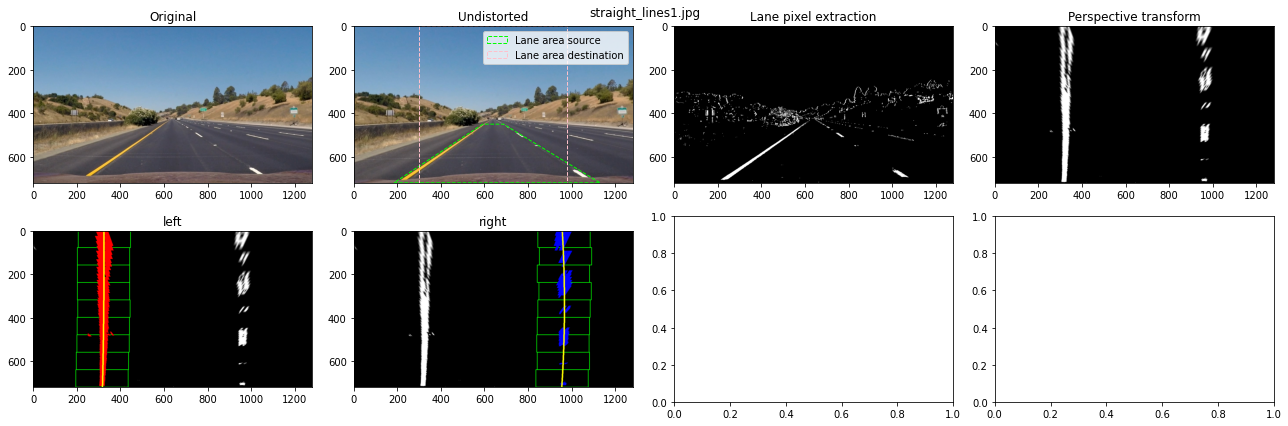

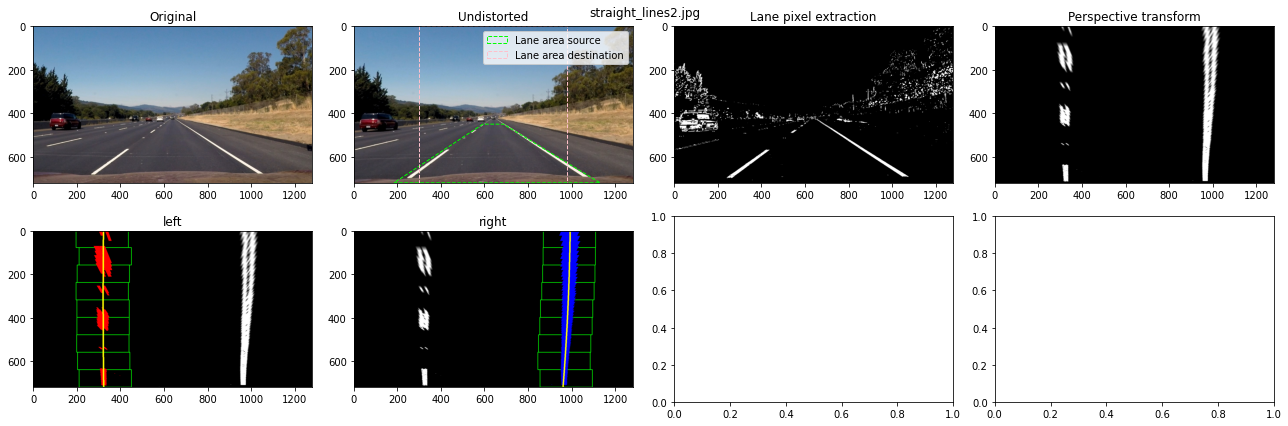

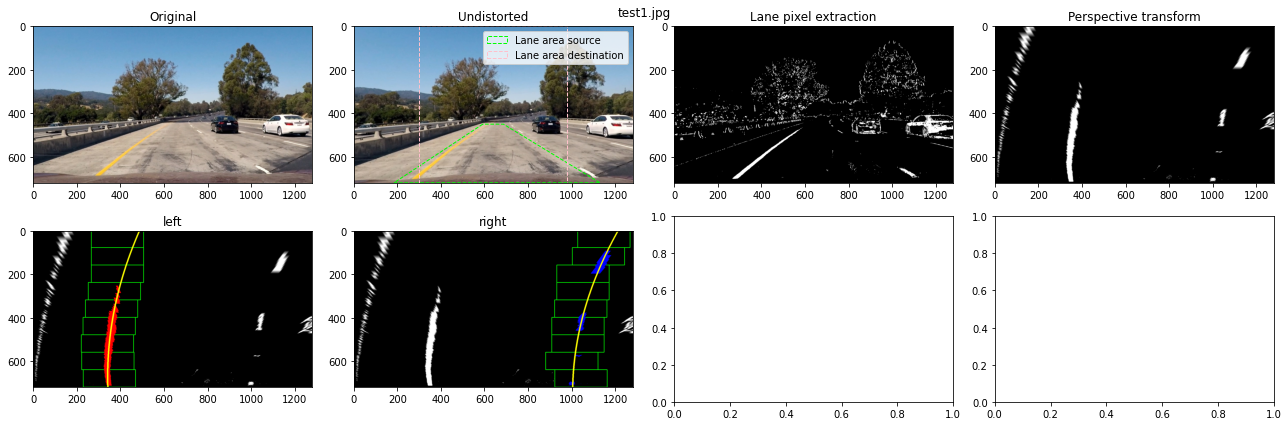

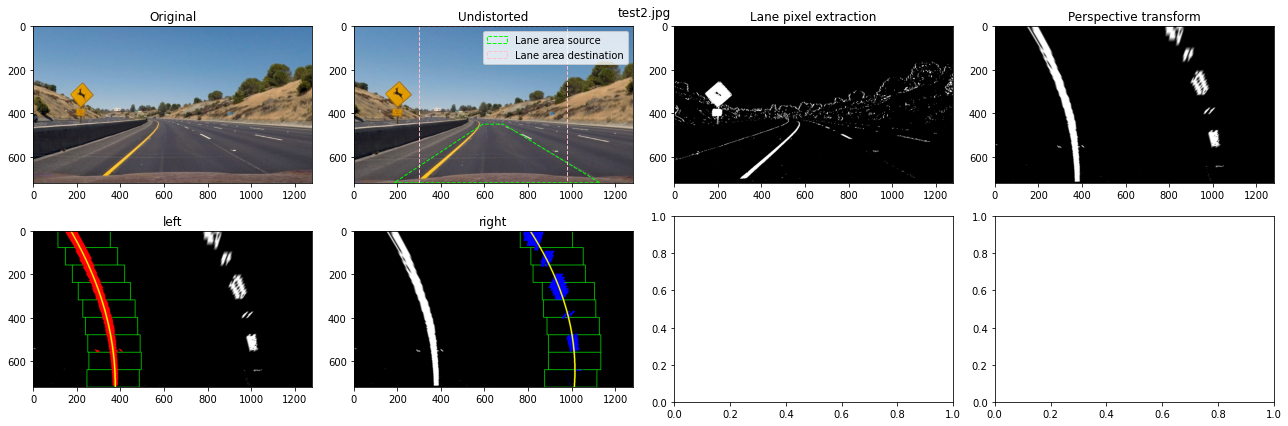

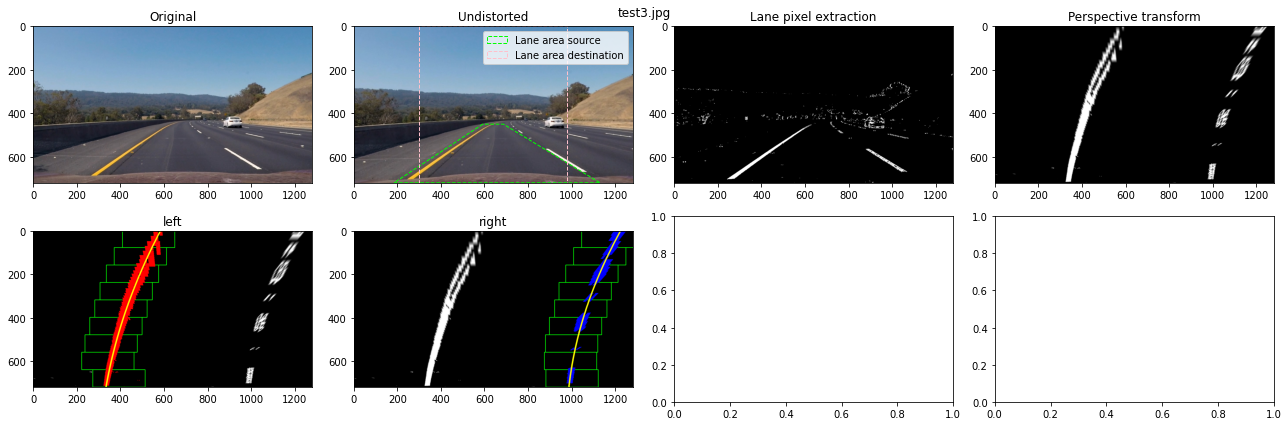

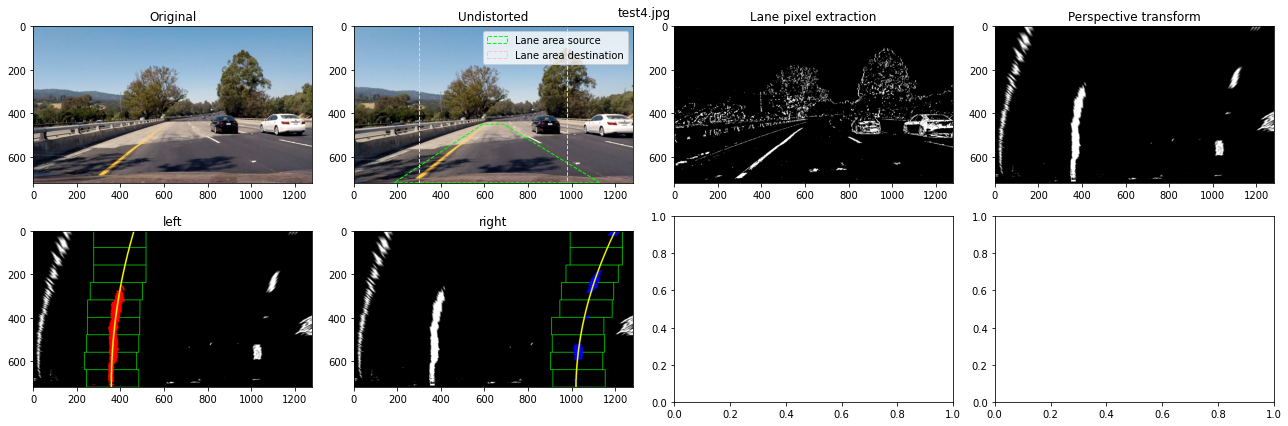

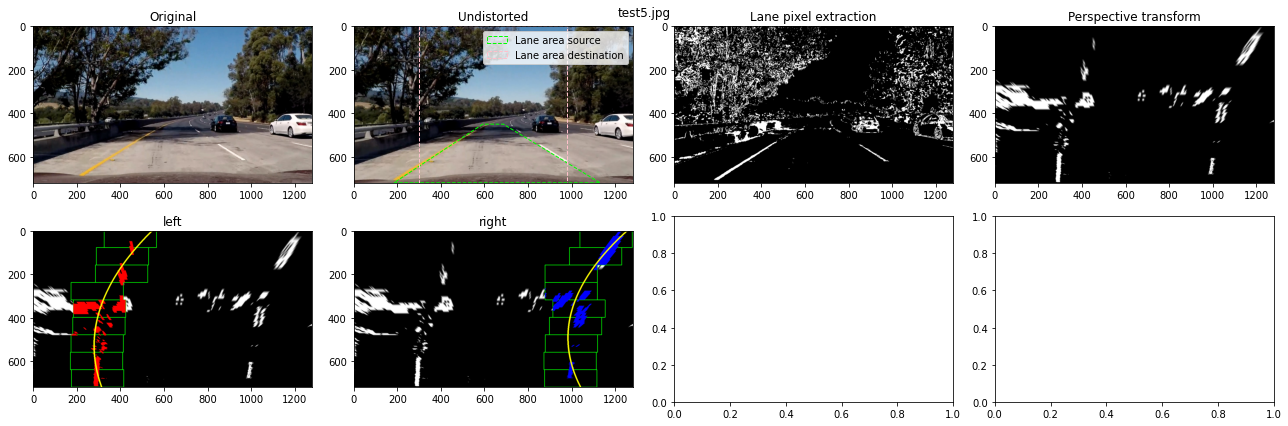

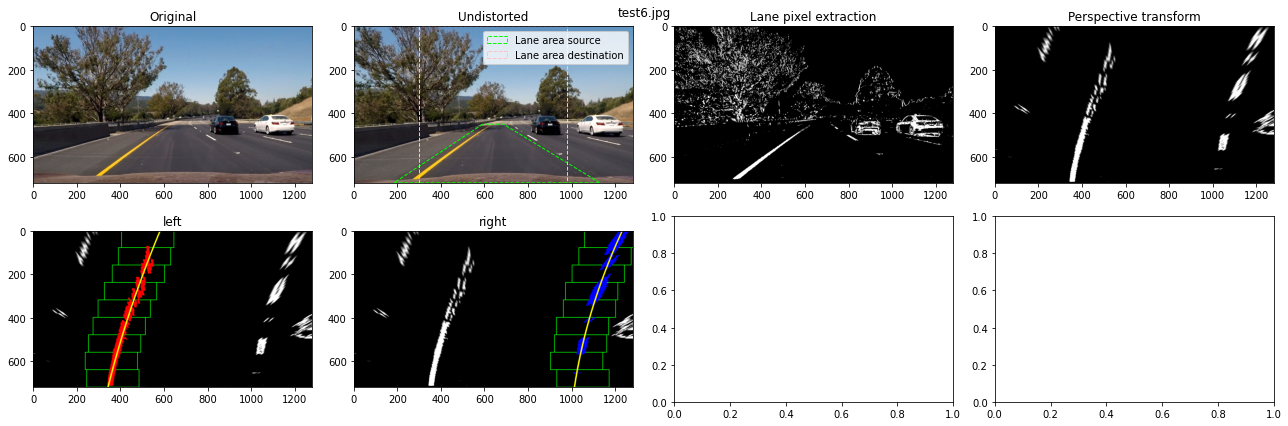

In [18]:
for img_path in TEST_IMAGES:
    _, ((t1, t2, t3, t4), (b1, b2, b3, b4)) = plt.subplots(nrows=2, ncols=4, figsize=(18, 6))
    img_dist = cv2.imread(str(img_path))
    
    img = undist.apply(img_dist)
    
    t1.imshow(cv2.cvtColor(img_dist, cv2.COLOR_BGR2RGB))
    t1.set_title("Original")
    
    t2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    t2.set_title("Undistorted")
    
    t2.add_patch(Polygon(LANE_AREA_SRC, linewidth=1, edgecolor="lime", facecolor="none", 
                        linestyle="--", label="Lane area source"))
    t2.add_patch(Polygon(LANE_AREA_DST, linewidth=1, edgecolor="pink", facecolor="none", 
                        linestyle="--", label="Lane area destination"))
    t2.legend()
    
    img_bin = binarize_lane_line_pixels(img, output_binary=True, s_thresh=(155, 255),  sx_thresh=(40, 140))
    cmap = "gray" if len(img_bin.shape) == 2 else None
    t3.imshow(img_bin, cmap=cmap)
    t3.set_title("Lane pixel extraction")

    img_bird = bird_trans.apply(img_bin)
    t4.imshow(img_bird, cmap=cmap)
    t4.set_title("Perspective transform")

    for lt, ax in zip((LineType.LEFT, LineType.RIGHT), ((b1, b2))):
        l = Line.from_sliding_window(img_bird, lt)
        ax.imshow(l.sw_fit_viz)
        ax.set_title(LineType.to_str(lt))
        

    # Determine curvature and position of vehicle w.r.t. center
        
    # Warp lane lines back onto undistorted image + add curvature and position of vehicle details

        
    plt.suptitle(img_path.name)
    plt.savefig("test_images_output/steps_" + img_path.stem + ".png")
    plt.tight_layout()
    plt.show()
    plt.close()
